In [1]:
!pip install yfinance pandas matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define our Ticker and Timeframe
ticker = 'SPY'
start_date = '2010-01-01'
end_date = '2023-12-31'

# 2. Download the data
data = yf.download(ticker, start=start_date, end=end_date)

# 3. Display the first 5 rows to see what we got
print(data.head())

C:\Users\Graduate\AppData\Local\Temp\ipykernel_22440\2789004573.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker            SPY        SPY        SPY        SPY        SPY
Date                                                             
2010-01-04  85.279221  85.324368  83.909697  84.556835  118944600
2010-01-05  85.504951  85.542578  84.918014  85.226535  111579900
2010-01-06  85.565163  85.775858  85.354468  85.422189  116074400
2010-01-07  85.926323  86.031670  85.166311  85.407106  131091100
2010-01-08  86.212265  86.249892  85.527506  85.700575  126402800


In [3]:
print (data.columns)

MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [4]:
# --- 1. Define our trend-line windows ---
short_window = 50
long_window = 200

# --- 2. Calculate the SMAs ---
# This creates two new columns in our 'data' spreadsheet
# .rolling(window=...) creates a 50-day sliding window
# .mean() calculates the average of that window
#
# **THIS IS THE LINE WE FIXED**
# We use 'Close' instead of 'Adj Close'
data['SMA_50'] = data['Close'].rolling(window=short_window).mean()
data['SMA_200'] = data['Close'].rolling(window=long_window).mean()

# --- 3. Create the "Signal" ---
# This is our raw rule.
# We create a new 'Signal' column, default to 0 (meaning "Hold Cash")
data['Signal'] = 0

# Find all rows where SMA_50 > SMA_200 and set 'Signal' to 1 (meaning "Buy")
data.loc[data['SMA_50'] > data['SMA_200'], 'Signal'] = 1

# --- 4. Create the "Position" ---
# This is the MOST important concept: "No Crystal Balls"
#
# We can't use today's closing price to decide to buy today.
# We get the signal at the *end* of the day (at the close).
# We can only act on it (take a position) on the *next day's* open.
#
# .shift(1) "shifts" the entire 'Signal' column down by one day.
# So, today's 'Position' is based on *yesterday's* 'Signal'.
# This avoids "lookahead bias" and makes our test realistic.
data['Position'] = data['Signal'].shift(1)

# Let's look at the end of the data to see our new columns
# You'll see "NaN" (Not a Number) for the first 200 rows.
# This is normal! We needed 200 days of data to calculate the first SMA_200.
print("\nLast 5 rows with our new signals:")
print(data.tail())


Last 5 rows with our new signals:
Price            Close        High         Low        Open     Volume  \
Ticker             SPY         SPY         SPY         SPY        SPY   
Date                                                                    
2023-12-22  463.589172  465.282436  461.680610  463.794703   67160400   
2023-12-26  465.546692  466.456931  463.921948  464.000266   55387000   
2023-12-27  466.388428  466.535236  464.802843  465.341149   68000300   
2023-12-28  466.564606  467.406324  466.143747  466.750572   77158100   
2023-12-29  465.213898  466.897364  463.246583  466.368826  122283100   

Price           SMA_50     SMA_200 Signal Position  
Ticker                                              
Date                                                
2023-12-22  434.895891  420.263281      1      1.0  
2023-12-26  435.794244  420.730724      1      1.0  
2023-12-27  436.620919  421.205027      1      1.0  
2023-12-28  437.451508  421.649504      1      1.0  
2023-12-2

In [5]:
# --- 1. Calculate Benchmark Returns (Buy and Hold) ---
data['Market_Returns'] = data['Close'].pct_change()

# --- 2. Calculate our Strategy Returns ---
# (Market Return) * (Our Position)
data['Strategy_Returns'] = data['Market_Returns'] * data['Position']

data.fillna(0, inplace=True)
# --- 3. Calculate Cumulative Returns (Equity Curves) ---
# We add 1 to the returns (e.g., 0.01 becomes 1.01)
# Then we use .cumprod() to compound them, showing $1 growth
data['Cumulative_Market'] = (1 + data['Market_Returns']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy_Returns']).cumprod()

print("\nLast 5 rows with our backtest results:")
print(data.tail())


Last 5 rows with our backtest results:
Price            Close        High         Low        Open     Volume  \
Ticker             SPY         SPY         SPY         SPY        SPY   
Date                                                                    
2023-12-22  463.589172  465.282436  461.680610  463.794703   67160400   
2023-12-26  465.546692  466.456931  463.921948  464.000266   55387000   
2023-12-27  466.388428  466.535236  464.802843  465.341149   68000300   
2023-12-28  466.564606  467.406324  466.143747  466.750572   77158100   
2023-12-29  465.213898  466.897364  463.246583  466.368826  122283100   

Price           SMA_50     SMA_200 Signal Position Market_Returns  \
Ticker                                                              
Date                                                                
2023-12-22  434.895891  420.263281      1      1.0       0.002010   
2023-12-26  435.794244  420.730724      1      1.0       0.004223   
2023-12-27  436.620919  421.20

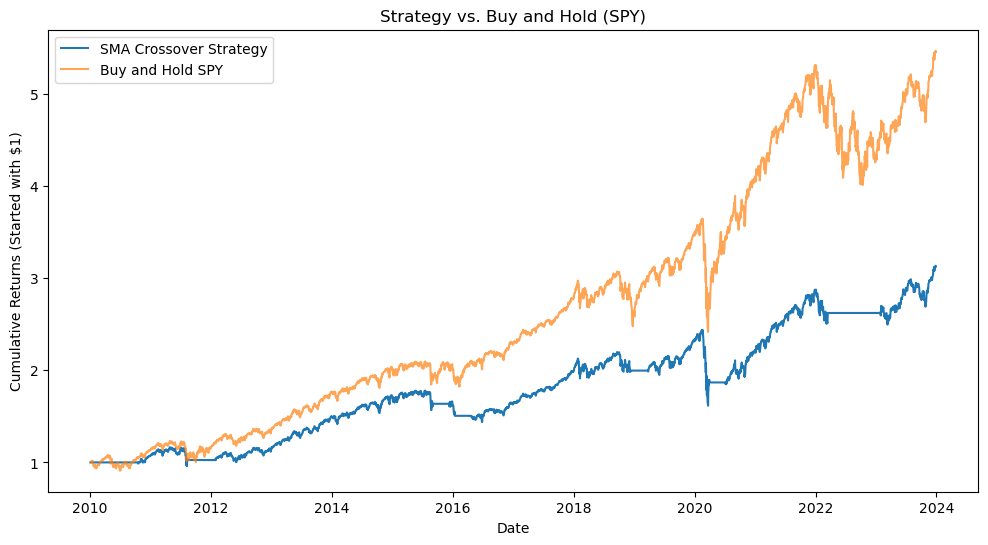

In [6]:
# --- 1. Create the plot ---
plt.figure(figsize=(12, 6)) # Set a nice big size

# --- 2. Plot our two equity curves ---
# We plot the 'Date' (the index) vs. the cumulative values
plt.plot(data.index, data['Cumulative_Strategy'], label='SMA Crossover Strategy')
plt.plot(data.index, data['Cumulative_Market'], label='Buy and Hold SPY', alpha=0.7) # alpha=0.7 makes it slightly transparent

# --- 3. Add titles and labels ---
plt.title('Strategy vs. Buy and Hold (SPY)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Started with $1)')
plt.legend() # Show the legend

# --- 4. Show the plot ---
plt.show()

In [7]:
# --- 1. Calculate Max Drawdown ---
# We calculate the "peak" value our portfolio has ever reached
data['Peak'] = data['Cumulative_Strategy'].cummax()

# We calculate the drawdown: (% drop from the last peak)
data['Drawdown'] = (data['Cumulative_Strategy'] - data['Peak']) / data['Peak']

# We find the *worst* (minimum) drawdown value
max_drawdown = data['Drawdown'].min()

# --- 2. Calculate Sharpe Ratio ---
# We need the *daily* returns, not the cumulative ones
# We'll use 252 as the number of trading days in a year
#
# First, get the average *daily* return
mean_daily_return = data['Strategy_Returns'].mean()

# Next, get the *standard deviation* of daily returns (this is our "risk")
std_daily_return = data['Strategy_Returns'].std()

# Annualize them to get the Sharpe Ratio
# We assume risk-free rate is 0
sharpe_ratio = (mean_daily_return * 252) / (std_daily_return * (252**0.5))


# --- 3. Print the Results ---
print("--- Strategy Performance ---")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")

# Let's also get the benchmark's numbers for comparison
benchmark_sharpe = (data['Market_Returns'].mean() * 252) / (data['Market_Returns'].std() * (252**0.5))
benchmark_peak = data['Cumulative_Market'].cummax()
benchmark_drawdown = (data['Cumulative_Market'] - benchmark_peak) / benchmark_peak
benchmark_max_drawdown = benchmark_drawdown.min()

print("\n--- Benchmark (Buy and Hold) Performance ---")
print(f"Sharpe Ratio: {benchmark_sharpe:.2f}")
print(f"Max Drawdown: {benchmark_max_drawdown*100:.2f}%")

--- Strategy Performance ---
Sharpe Ratio: 0.66
Max Drawdown: -33.72%

--- Benchmark (Buy and Hold) Performance ---
Sharpe Ratio: 0.79
Max Drawdown: -33.72%
